## Project Assignment: Diabetes

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic 
measurements whether a patient has diabetes. In this study, we will be considering only women and 21 of age. This dataset is from 1990. 

Here are the different constraints: 

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

In [88]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from io import StringIO
from IPython.display import Image  
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, precision_score, f1_score
import pydotplus

from LogReg import LogisticRegressor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error

In [89]:
#Import the data
df = pd.read_csv("diabetes.csv")
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X=np.array(X)
y=np.array(y)

## Logistic Regression

Now, we will start by doing a Logistic Regression. I chose to do this model for my dataset because...

In [90]:
def train_test_split(X, y, test_size=0.2, stratify=y, random_state=42):
    """
    Splits arrays or matrices into random train and test subsets. This function demonstrates how to 
    divide a dataset into training and testing sets, optionally stratifying the samples and ensuring 
    reproducibility with a random state.

    Parameters:
    - X (np.ndarray): Input features matrix, where rows represent samples and columns represent features.
    - y (np.ndarray): Target labels array, aligned with the samples in X.
    - test_size (float or int): Determines the size of the test set. If float, it represents a proportion 
                                of the dataset; if int, it specifies the number of samples.
    - stratify (np.ndarray): If provided, the function will ensure the class proportions in train and test 
                             sets mirror those of the provided array, typically the target labels array.
    - random_state (int): Seed for the random number generator to ensure reproducible splits.

    Returns:
    - X_train, X_test, y_train, y_test: Arrays containing the split of features and labels into training and 
                                        test sets.
    """
    
    # Set the seed for reproducibility
    if random_state:
        np.random.seed(random_state)

    # Determine the number of samples to allocate to the test set
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        n_test = int(n_samples * test_size)
    else:
        n_test = test_size
    n_train = n_samples - n_test

    # Create an array of indices and shuffle if not stratifying
    indices = np.arange(n_samples)
    if stratify is None:
        np.random.shuffle(indices)
    else:
        # For stratified splitting, determine the distribution of classes
        unique_classes, y_indices = np.unique(stratify, return_inverse=True)
        class_counts = np.bincount(y_indices)
        test_counts = np.round(class_counts * test_size).astype(int)

        # Allocate indices to train and test sets preserving class distribution
        train_indices, test_indices = [], []
        for class_index in range(len(unique_classes)):
            class_indices = indices[y_indices == class_index]
            np.random.shuffle(class_indices)
            boundary = test_counts[class_index]
            test_indices.extend(class_indices[:boundary])
            train_indices.extend(class_indices[boundary:])

        # Concatenate indices to form the final split
        indices = train_indices + test_indices

    # Use the indices to partition the dataset
    X_train = X[indices[:n_train]]
    X_test = X[indices[n_train:]]
    y_train = y[indices[:n_train]]
    y_test = y[indices[n_train:]]

    return X_train, X_test, y_train, y_test


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [92]:
# Configuration of logistic regression model
num_iterations = 1500      # Number of iterations to run the gradient_descent algorithm
learning_rate = 1e-4      # Learning rate parameter for gradient descent

logistic = LogisticRegressor()

logistic.fit(X_train, y_train, learning_rate=learning_rate, num_iterations=num_iterations, verbose=True, penalty="elasticnet")

y_train_prob = logistic.predict_proba(X_train)
y_test_prob = logistic.predict_proba(X_test)
print(accuracy_score(y_train, logistic.predict(X_train)))
print(accuracy_score(y_test, logistic.predict(X_test)))


Iteration 0: Loss 0.6931471805599453
Iteration 100: Loss 0.6220442793412672
Iteration 200: Loss 0.619642311225076
Iteration 300: Loss 0.6186652497577492
Iteration 400: Loss 0.6179569141773886
Iteration 500: Loss 0.6173672997805876
Iteration 600: Loss 0.6168477402281264
Iteration 700: Loss 0.6163771335950956
Iteration 800: Loss 0.6159447894781942
Iteration 900: Loss 0.6155445150544397
Iteration 1000: Loss 0.6151722629128172
Iteration 1100: Loss 0.6148251083220616
Iteration 1200: Loss 0.6145007690956106
Iteration 1300: Loss 0.6141973630054314
Iteration 1400: Loss 0.6139132763749764
0.6910569105691057
0.6862745098039216


In [93]:
y_train_predictions =  (y_train_prob > 0.5).astype(int)
y_test_predictions =  (y_test_prob > 0.5).astype(int)

#### Visual Analysis 

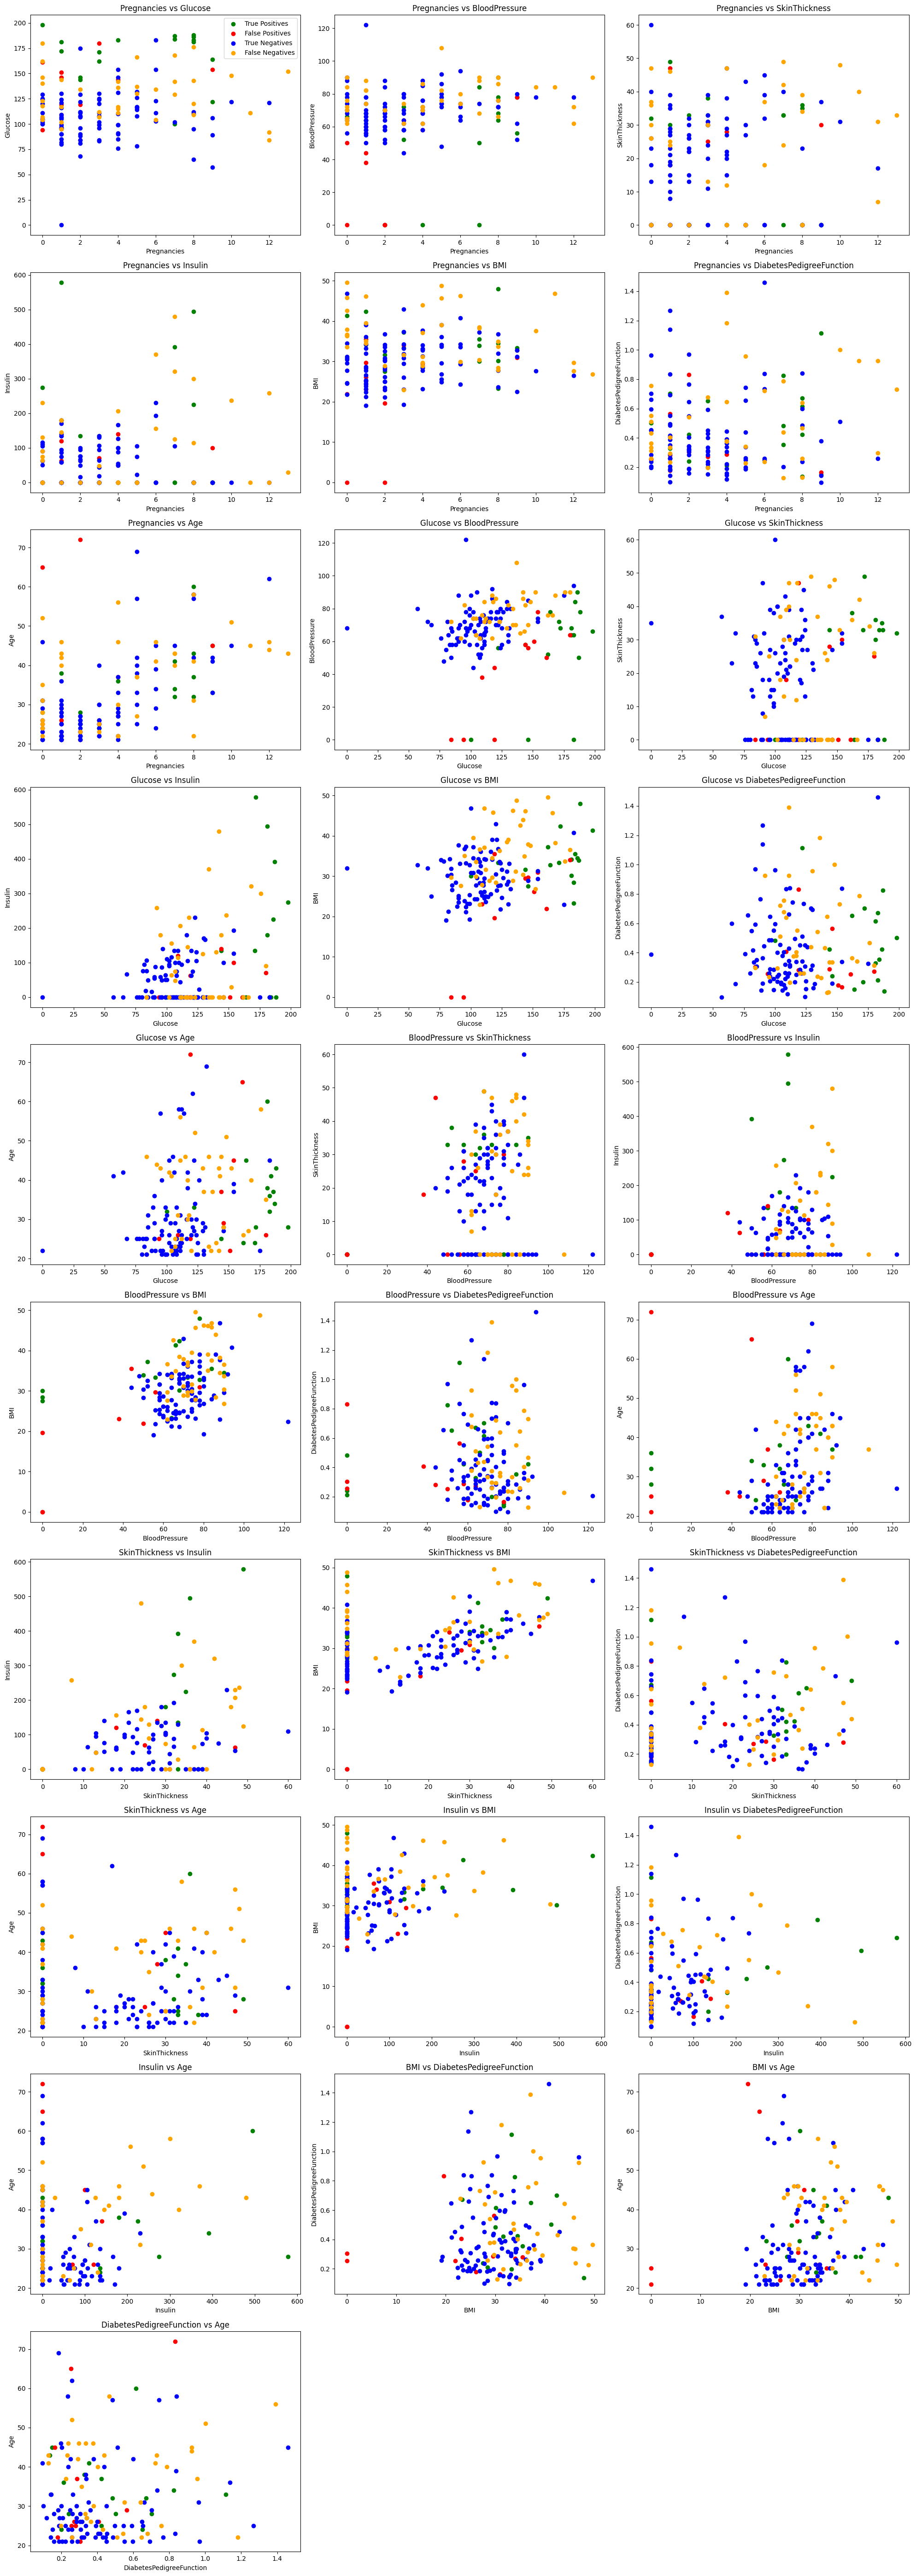

In [94]:
from itertools import combinations

# Define the true positives, false positives, true negatives, and false negatives
true_positives = (y_test == 1) & (y_test_predictions == 1)
false_positives = (y_test == 0) & (y_test_predictions == 1)
true_negatives = (y_test == 0) & (y_test_predictions == 0)
false_negatives = (y_test == 1) & (y_test_predictions == 0)

# Get the feature names
feature_names = df.columns[:-1]

# Create subplots
num_features = X_test.shape[1]
num_combinations = len(list(combinations(range(num_features), 2)))
fig, axes = plt.subplots(nrows=num_combinations // 3 + 1, ncols=3, figsize=(20, num_combinations * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the results for each combination of two features
for idx, (feature1, feature2) in enumerate(combinations(range(X_test.shape[1]), 2)):
    ax = axes[idx]
    ax.scatter(X_test[true_positives, feature1], X_test[true_positives, feature2], color='green', label='True Positives')
    ax.scatter(X_test[false_positives, feature1], X_test[false_positives, feature2], color='red', label='False Positives')
    ax.scatter(X_test[true_negatives, feature1], X_test[true_negatives, feature2], color='blue', label='True Negatives')
    ax.scatter(X_test[false_negatives, feature1], X_test[false_negatives, feature2], color='orange', label='False Negatives')

    ax.set_xlabel(feature_names[feature1])
    ax.set_ylabel(feature_names[feature2])
    ax.set_title(f'{feature_names[feature1]} vs {feature_names[feature2]}')

# Add legend to the first subplot
axes[0].legend()

# Hide any unused subplots
for ax in axes[num_combinations:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [95]:
y_pred = logistic.predict(X_train)
print(y_pred.shape)

(615,)


In [96]:
#Evaluation metrics
y_pred = logistic.predict(X_test)
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy_score = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy_score)

precision_score = precision_score(y_test, y_pred)
print("Precision score:", precision_score)

f1_score = f1_score(y_test, y_pred)
print("f1_score:", f1_score)


[[88 11]
 [37 17]]
Accuracy score: 0.6862745098039216
Precision score: 0.6071428571428571
f1_score: 0.4146341463414634


### Analysis

By looking at the metrics of my regression model, we can see that the model isn't very accurate. All of the metrics are pretty low which shows that our model isn't able to predict really well whether a person has diabetes or not. We also have the confirmation when looking at the previous graph, because there isn't a clear separation with the features Glucose + Age. I tried changing the features to see if there is a better combination but this combination is the best one found. By looking at the graph, we can also say that the model has a lot of False Negatives (as the confusion matrix shows). We can assume that the data is not linearly seperable.